## Plot 2: One example exam season day with 25% - 75% Qauntile of the average over the years

- for simplicity only one example day was chosen with only 3 location which show different patterns over the day
- plotted is tuesday of the fifth week of the year which is in the middle of our winter exam phase (calendar week 3-8 and 29 - 32)
- to address uncertaincys and changes over the time frame a quantile band was added to the plot 

Data processing steps:
-  first filtered to Tuesdays of calendar week 5 across all available years
- Timestamps are aligned to 10-minute time-of-day bins
- For each year, location, and time bin, availability is averaged to obtain the year-level 
- year-level values are aggregated across years to compute the mean and interquartile range

Only opening hours (07:00–24:00) are shown and shaded region describes closing time of hill library.

Interpretation: The figure shows historical availability patterns and their inter-annual variability under exam-period conditions, not a real-time forecast.

In [2]:
import pandas as pd
import datetime as dt

# Function to load a CSV file
def load_csv_file(file_path):
    """Loads a CSV file into a pandas DataFrame and returns it."""
    try:
        df = pd.read_csv(file_path)
        # print(f"Successfully loaded '{file_path}'. Head of the DataFrame:")
        # print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None

In [3]:
# load the data 
data = load_csv_file("data/final_data.csv")
data.head()


,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
0,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
1,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
2,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
3,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN


In [4]:
# Ensure datetime
data["t10"] = pd.to_datetime(data["t10"])

# Extract ISO year and week
iso = data["t10"].dt.isocalendar()
data["iso_year"] = iso.year
data["iso_week"] = iso.week
data["weekday"] = data["t10"].dt.weekday


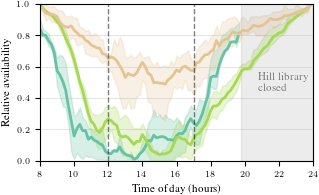

In [13]:
import matplotlib.pyplot as plt

target_week = 5  

winter = data[
    (data["iso_week"] == target_week) &
    (data["weekday"] == 1)                  # to ensure we only use tuesdays 
].copy()

# Bin into 10-minute slots
winter["time_bin"] = (winter["t10"].dt.hour * 60 + winter["t10"].dt.minute) // 10 * 10
winter["time_of_day_10min"] = winter["time_bin"] / 60  

# Restrict to opening hours (7-24)
winter = winter[winter["t10"].dt.hour.between(7, 24)]

# the mean availability for each location at each 10-minute time slot on Tuesday of week 5
yearly_loc = (
    winter
    .groupby(
        ["iso_year", "location_id", "time_of_day_10min"],
        as_index=False
    )["relative_availability"]
    .mean()
)

# Get location names from the original data
loc_names = data[["location_id", "longname"]].drop_duplicates().set_index("location_id")["longname"].to_dict()

# chosen example locations (hill and valley)
example_locations = [18, 5, 16]
location_types = {
    18: "hill",
    5: "valley",
    16: "valley"
}

# aggregation over the years and quantile calculation 
loc_summary = (
    yearly_loc[yearly_loc["location_id"].isin(example_locations)]
    .groupby(["location_id", "time_of_day_10min"])
    .agg(
        mean_avail=("relative_availability", "mean"),
        q25=("relative_availability", lambda x: x.quantile(0.25)),
        q75=("relative_availability", lambda x: x.quantile(0.75)),
    )
    .reset_index()
)

# using tueplots to ensure correct fond and fondsize of the figure for the report 
from tueplots import bundles

plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))

fig, ax = plt.subplots(1, 1)

# using colormap of matplotlib
cmap = plt.get_cmap("Set2")
colors = {
    18: cmap(0.0),    
    5: cmap(0.5),    
    16: cmap(0.85),   
}


# Plot locations
for loc in example_locations:
    d = loc_summary[loc_summary["location_id"] == loc]
    loc_label = loc_names.get(loc, f"Location {loc}")
    loc_type = location_types.get(loc, "")
    full_label = f"{loc_label} ({loc_type})"

    ax.plot(
        d["time_of_day_10min"],
        d["mean_avail"],
        linewidth=2,
        color=colors[loc],
        label=full_label,
    )

    ax.fill_between(
        d["time_of_day_10min"],
        d["q25"],
        d["q75"],
        color=colors[loc],
        alpha=0.25,
    )

ax.axvspan(19.75, 24, color="gray", alpha=0.15)
ax.text(
    20.8, 0.5,
    "Hill library\n closed",
    va="center",
    color="gray"
)

# Add vertical lines for time periods
ax.axvline(12, color="black", linestyle="--", linewidth=1, alpha=0.5)
ax.axvline(17, color="black", linestyle="--", linewidth=1, alpha=0.5)

# Add text labels for time periods at the top
#ax.text(11.75, 0.9, "Morning", ha="right", alpha=0.7)
#ax.text(14.5, 0.9, "Afternoon", ha="center",  alpha=0.7)
#ax.text(17.25, 0.9, "Evening", ha="left",  alpha=0.7)

ax.set_xlabel("Time of day (hours)")
ax.set_ylabel("Relative availability")
ax.set_xlim(8, 24)
ax.set_ylim(0, 1)
ax.grid(axis="y", alpha=0.3)



#ax.legend(frameon=False, loc="lower right")

plt.savefig("plots/exampleDay_icml.pdf")
plt.show()

Limitation:
- relative availability of PCB-Bibliothek start not with 1 because the estimations begann shortly before and ended shortly after the official opening hours (noticed during data cleaning)
- since the building is busy because of lectures/seminars its possible, that the people are already right before the doors or they let people in early
- because there are less overall seats in pcb in comparison to e.g. ammerbau this has a bigger impact
- the quantile bands show that there was a lot of deviation across the years espacially at the day times where the library reaches almost full capacity 
- this is a limitation to our recomendation system

Interpretation: 
- while in PCB and Ammerbau the occupancy is overall very high Waschhalle seems to be less crowded
- also relative availability in the morning in Ammerbau is higher than PCB but changes during miday -> after the lunch break the PCB has a higher relative availability 

